In [1]:
import os
import sys
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
from math import pi
import h5py
import orbithunter as orb
%matplotlib notebook

# Developer Guide

This notebook acts to serve as an interactive example of the [developer's guide](https://orbithunter.readthedocs.io/en/latest/guide.html). It's goal is to show how easy it is to implement your equations,
and the relatively small number of functions and methods required to yield access to all of the tools that orbithunter provides. To do so I will work with the Lorenz equation; a dynamical system defined for the coordinates `(x, y, z)`. In the
spatiotemporal formulation, only `t` is a continuous dimension; x, y, z are coupled bit their concatenation does not correspond to a continuous field dimension. Therefore, for every orbit, the discretization will be represented by an array of dimension
$(N, 3)$. This is a simple example of a non-trivial system. Additionally, I have only experienced good results with spectral methods, an implicity assumption of the code. 

To break this down into pieces, I will first define all required functions ***outside*** of the class definition, and then collect them all at the end.

\begin{eqnarray}
 \dot{x} = \sigma(y-x) \\
 \dot{y} = \rho x - y - xz \\
 \dot{z} = xy - bz
\end{eqnarray}

The equations will be solved as a system of differential algebraic equations

\begin{eqnarray}
 \omega_j \tilde{x} - \sigma(\tilde{y} - \tilde{x}) = 0 \\
 \omega_j \tilde{y} - \rho \tilde{x} + \tilde{y} + \mathcal{F}(x \cdot z) = 0 \\
 \omega_j \tilde{z} - \mathcal{F}(x\cdot y) + b \tilde{z} = 0.
\end{eqnarray}
Because we have discretized an entire time series, note that the tilde variables are ***vectors*** of Fourier modes.

Where it is understood that $x\cdot y$ is the nonlinear term computed as a product in physical space and variables
marked by $~$ are The temporal Fourier modes of the coordinates $(x, y, z)$

The defaults are set such that $t\in(0, 100), \sigma=10,\rho=20, b=8/3$




We can now move onto the methods which actually evaluate the functions. I will
be working under the assumption that the default cost function is to be used:
$\frac{F^2}{2}$. We must implement the transforms first. Because we have parameters which are real-valued, it will benefit us to make the equations real valued.

In [2]:
from scipy.fft import rfft, irfft, rfftfreq
import numpy as np

from functools import lru_cache
@lru_cache()
def temporal_frequencies(t, n, order):
    """
    Matrix/rank 2 tensor of temporal mode frequencies

    Parameters
    ----------
    t : float
        Temporal period
    n : int
        Temporal discretization size
    order : int
        The order of the derivative/power of the frequencies desired.

    Returns
    ----------
    dtn_multipliers : np.ndarray
        Array of spatial frequencies in the same shape as modes

    Notes
    -----
    Creates and returns a rank 2 tensor whose elements are the properly ordered temporal frequencies,
    which is the same shape as the spatiotemporal Fourier mode state. The elementwise product
    with a set of spatiotemporal Fourier modes.

    """
    # Extra factor of -1 because of time ordering in array.
    # Extra factor of -1 because of time ordering in array.
    w = (-1 * (2 * pi * n / t) * rfftfreq(n)[1:-1]) ** order
    # Coefficients which depend on the order of the derivative, see SO(2) generator of rotations for reference.
    c1, c2 = np.sign(1j ** order).real, np.sign((-1j) ** order).real
    # The Nyquist frequency is never included, this is how time frequency modes are ordered.
    # Elementwise product of modes with time frequencies is the spectral derivative.
    return np.concatenate(([0], c1 * w, c2 * w))[:, np.newaxis]


def swap_modes(modes, axis=0):
    """
    Function which swaps real, imaginary components of arrays for SO(2) differentiation

    Parameters
    ----------
    modes : np.ndarray
        Array of Fourier modes,
    axis : int
        Whether to swap along time (0) or space(1) dimension
    Notes
    -----
        Both real and imaginary components are stored as real numbers. See class transforms for details.

    """
    if axis == 1:
        m = modes.shape[1] // 2
        t_dim = modes.shape[0]
        swapped_modes = np.concatenate(
            (modes[:, -m:].reshape(t_dim, -1), modes[:, :-m].reshape(t_dim, -1)), axis=1
        )
    else:
        n = (modes.shape[0] + 1) // 2 - 1
        # do not need the special case as .dt() shouldn't be used for either subclass mentioned above.
        swapped_modes = np.concatenate(
            (modes[None, 0, :], modes[-n:, :], modes[1:-n, :]), axis=0
        )
    return swapped_modes

class OrbitLZ(orb.Orbit):

    def transform(self, to=None):
        if self.state is None:
            raise ValueError(
                "Trying to transform an unpopulated {} instance.".format(str(self))
            )
        elif self.basis is None:
            raise ValueError(
                "Trying to transform state with unknown basis".format(str(self))
            )

        if to == "xyz":
            if self.basis == "modes":
                return self._inv_time_transform()
            else:
                return self
        elif to == "modes":
            if self.basis == "xyz":
                return self._time_transform()
            else:
                return self
        else:
            raise ValueError("Trying to transform to unrecognized basis.")

    def _time_transform(self):

        xyz = self.state
        modes = rfft(xyz, axis=0, norm='ortho')
        # do not include nyquist frequency (last row)
        modes = np.concatenate((modes.real[:-1, :], modes.imag[1:-1, :]), axis=0)
        # So that F^T = F^{-1}
        modes[1:, :] = np.sqrt(2) * modes[1:, :]
        return self.__class__(**{**vars(self), 'state':modes, 'basis':"modes"})

    def _inv_time_transform(self):
        # Take rfft, accounting for unitary normalization.
        # Take rfft, accounting for unitary normalization.
        modes = self.state.astype(complex)
        if modes.shape[0] > 1:
            modes[1 : -max([int(self.n // 2) - 1, 1]), :] += (
                1j * modes[-max([int(self.n // 2) - 1, 1]) :, :]
            )
            # if first statement evaluates to zero, then take all rows of
            # axis by providing None as end of slice.
            n_rows = (-max([int(self.n // 2) - 1, 1]) + 1) or None
            modes = modes[:n_rows, :]
            modes[1:, :] /= np.sqrt(2)
            if modes.shape[0] == 1:
                modes = np.pad(modes, ((0, 1), (0, 0)))
            modes[-1, :] = 0
        else:
            if modes.shape[0] == 1:
                modes = np.pad(modes, ((0, 1), (0, 0)))
            modes[-1, :] = 0
        xyz = irfft(modes, axis=0, norm='ortho')
        return self.__class__(**{**vars(self), 'state':xyz, 'basis':"xyz"})

    def dimensions(self):
        """
        Dimensions of the spatiotemporal tile (configuration space).

        Returns
        -------
        tuple :
            Tuple of dimensions, typically this will take the form (t, x, y, z) for (3+1)-D spacetime

        Notes
        -----
        Because this is usually a subset of self.parameters, it does not use the property decorator. This method
        is purposed for readability and other reasons where only dimensions are required.

        """
        return self.t, 
    
    @staticmethod
    def bases_labels():
        return "xyz", "modes"
    
    @staticmethod
    def parameter_labels():
        return 't', 'sigma', 'rho', 'b'
    
    @staticmethod
    def discretization_labels():
        """
        Labels for time and spatial dimensions; space is treated as a vector of 3 
        coordinates

        """
        return 'n', 'ijk'
    
    @staticmethod
    def dimension_labels():
        return 't', 'ijk'
    
    @staticmethod
    def minimal_shapes():
        return 2, 3
    
    @staticmethod
    def minimal_shape_increments():
        return 1, 0
    
    @staticmethod
    def continuous_dimensions():
        return True, False

    @staticmethod
    def _default_shape():
        return 4, 3

    @staticmethod
    def _default_parameter_ranges():
        return {'t': (0, 100), 'sigma':10, 'rho':28, 'b':8./3.}
    
    @staticmethod
    def _default_constraints():
        return {'t': False, 'sigma':True, 'rho': True, 'b':True}
    
    @classmethod
    def _dimension_indexing_order(cls):
        return False, True
    
    def orbit_vector(self):
        return np.concatenate((self.state.ravel(), self.parameters)).reshape(-1, 1)
    
    def _pad(self, size, axis=0):
        """
        Increase the size of the discretization via zero-padding

        Parameters
        ----------
        size : int
            The new size of the discretization, must be an even integer
            larger than the current size of the discretization (handled by resize method).

        axis : int
            The dimension of the state that will be padded.

        Returns
        -------
        OrbitKS :
            OrbitKS instance with larger discretization.

        Notes
        -----
        Need to account for the normalization factors by multiplying by old, dividing by new.

        """
        modes = self.transform(to="modes")
        if axis == 0:
            # Due to formatting, can prepend and append zeros to second half as opposed to appending
            # to first and second halves.
            padding = (size - modes.n) // 2
            padding_tuple = ((padding, padding), (0, 0))
            padded_modes = np.concatenate(
                (
                    modes.state[: -(modes.n // 2 - 1), :],
                    np.pad(modes.state[-(modes.n // 2 - 1) :, :], padding_tuple),
                ),
                axis=0,
            )
            padded_modes *= np.sqrt(size / modes.n)
            return self.__class__(
                **{
                    **vars(self),
                    "state": padded_modes,
                    "basis": "modes",
                    "discretization": (size, 3),
                }
            ).transform(to=self.basis)

        else:
            return self
            
    def _truncate(self, size, axis=0):
        """
        Decrease the size of the discretization via truncation

        Parameters"
        ----------
        size : int
            The new size of the discretization, must be an even integer
            smaller than the current size of the discretization (handled by resize method).

        axis : int
            The dimension of the state that will be truncated.

        Returns
        -------
        OrbitKS :
            OrbitKS instance with smaller discretization.

        Notes
        -----
        Need to account for the normalization factors by multiplying by old, dividing by new.

        """
        modes = self.transform(to="modes")
        if axis == 0:
            truncate_number = int(size // 2) - 1
            # Split into real and imaginary components, truncate separately.
            first_half = modes.state[: truncate_number + 1, :]
            second_half = modes.state[
                -(modes.n // 2 - 1) : -(modes.n // 2 - 1) + truncate_number, :
            ]
            truncated_modes = np.sqrt(size / modes.n) * np.concatenate(
                (first_half, second_half), axis=0
            )
            return self.__class__(
                **{
                    **vars(self),
                    "state": truncated_modes,
                    "basis": "modes",
                    "discretization": (size, 3),
                }
            ).transform(to=self.basis)
        else:
            return self
        
    def plot(self):
        from mpl_toolkits import mplot3d
        import numpy as np
        import matplotlib.pyplot as plt

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        xyz = self.transform(to="xyz").state
        ax.plot3D(xyz[:,0], xyz[:, 1], xyz[:, 2], 'gray')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    def mode_plot(self):
        fig = plt.figure(figsize=(3,3))
        logstate = np.abs(self.transform(to='modes').state)
        logstate[logstate < 1e-10] = 1
        plt.imshow(np.log10(logstate), aspect='auto')
        plt.xticks((0, 1, 2), labels=('x', 'y', 'z'))
        lab = [0] + 2 * list(range(1, (self.n)//2))
        plt.yticks(range(self.n-1), lab)
        plt.colorbar()
        plt.show()
        
    def dt(self, order=1):
        """
        Spectral time derivatives of the current state.

        Parameters
        ----------
        order :int
            The order of the derivative.
        array : bool
            Whether or not to return a numpy array. Used for efficiency/avoiding construction of redundant
            Orbit instances.

        Returns
        ----------
        orbit_dtn : OrbitKS
            The class instance whose state is the time derivative in the spatiotemporal mode basis.

        Notes
        -----
        It is very often the case that the derivative in the field basis is desired. Instead of forcing
        the user to write self.transform(to='modes').dt().transform(to='field'), the functions are written
        to incur extra overhead by transforming behind the scenes. To avoid unnecessary slow down, the OrbitKS
        instances must be in the modes basis to compute self.eqn()

        """

        # Need mode basis to compute derivatives
        modes = self.transform(to="modes")
        # Elementwise multiplication of modes with frequencies, this is the derivative. Uses numpy broadcasting.
        dtn_modes = temporal_frequencies(self.t, self.n, order) * modes.state

        # If the order of the derivative is odd, then imaginary component and real components switch. Need to
        # account for this for our real-valued transforms.
        if np.mod(order, 2):
            dtn_modes = swap_modes(dtn_modes, axis=0)

        # To for numerical efficiency, NumPy arrays can be returned.
        # return the derivative in an instance whose basis is equivalent to the original basis of self.
        orbit_dtn = self.__class__(
            **{**vars(self), "state": dtn_modes, "basis": "modes"}
        )
        return orbit_dtn.transform(to=self.basis)
        
    def eqn(self, **kwargs):
        # Because x,y,z, independent .dt() from OrbitKS can be used!
        modes = self.transform(to="modes").copy()
        xyz = self.transform(to="xyz").copy()
        eqn_orbit = modes.dt()
        #can exploit broadcasting here: gives x^2, xy, xz
        xyz.state[:, 1] = (xyz.state[:, 0]*xyz.state[:, 1])
        xyz.state[:, 2] = (xyz.state[:, 0]*xyz.state[:, 2])
        
        fxyz = xyz.transform(to='modes')
        xy = fxyz.state[:, 1]
        xz = fxyz.state[:, 2]
        
        x = modes.state[:, 0]
        y = modes.state[:, 1]
        z = modes.state[:, 2]
        
        xt, yt, zt = eqn_orbit.state.T
        
        fx = xt-self.sigma * y + self.sigma * x
        fy = yt-self.rho * x + y + xz
        fz = zt-xy + self.b * z


        return self.__class__(state=np.concatenate((fx[:,None],fy[:,None],fz[:,None]),axis=1), basis='modes', parameters=self.parameters)
        
    def matvec(self, other, **kwargs):
        # Because x,y,z, independent .dt() from OrbitKS can be used!

        assert other.basis == 'modes' and self.basis=='modes'
        other_modes = other.__class__(
        **{**vars(self), "state": other.state, "basis": "modes"}
        )

        self_xyz = self.transform(to='xyz').copy()
        other_xyz = other_modes.transform(to="xyz").copy()

        matvec_orbit = other_modes.dt()
        pseudo = self.__class__(**{**vars(self), "state":
                                   np.zeros(self_xyz.shape), "basis":'xyz'})

        # F(z dx) + F(x dz)
        pseudo.state[:, 1] = (self_xyz.state[:, 2] * other_xyz.state[:, 0]
                                     + self_xyz.state[:, 0] * other_xyz.state[:, 2])
        # F(x dy) + F(y dx)
        pseudo.state[:, 2] = -1*(self_xyz.state[:, 1] * other_xyz.state[:, 0]
                                + self_xyz.state[:, 0] * other_xyz.state[:, 1]) 

        matvec_orbit += pseudo.transform(to='modes')

        # sigma * (dx - dy) + wdx
        matvec_orbit.state[:, 0] += (self.sigma * (other_modes.state[:, 0] - other_modes.state[:, 1]))
        # -rho dx + dy + wdy
        matvec_orbit.state[:, 1] += (-self.rho * other_modes.state[:, 0] + other_modes.state[:, 1])
        # b * dz + wdz
        matvec_orbit.state[:, 2] += self.b * other_modes.state[:, 2]

        dfdt = (-1/self.t)*self.dt()
        dt = other.parameters[0]
        matvec_orbit += dfdt*dt
        return matvec_orbit
        
    def rmatvec(self, other, **kwargs):
        # Because x,y,z, independent .dt() from OrbitKS can be used!

        assert other.basis == 'modes' and self.basis=='modes'
        other_modes = other.__class__(
        **{**vars(self), "state": other.state, "basis": "modes"}
        )

        self_xyz = self.transform(to='xyz')
        other_xyz = other_modes.transform(to="xyz")

        rmatvec_orbit = -1 * other_modes.dt()

        pseudo = self.__class__(**{**vars(self), "state":
                                   np.zeros(self_xyz.shape), "basis":'xyz'})

        # F(z dx) + F(x dz)
        pseudo.state[:, 1] = (self_xyz.state[:, 2] * other_xyz.state[:, 0]
                                     + self_xyz.state[:, 0] * other_xyz.state[:, 2])
        # F(x dy) + F(y dx)
        pseudo.state[:, 2] = -1*(self_xyz.state[:, 1] * other_xyz.state[:, 0]
                                + self_xyz.state[:, 0] * other_xyz.state[:, 1]) 

        rmatvec_orbit += pseudo.transform(to='modes')

        # sigma * (dx - dy) - wdx
        rmatvec_orbit.state[:, 0] += (self.sigma * (other_modes.state[:, 0] - other_modes.state[:, 1]))
        # -rho dx + dy - wdy
        rmatvec_orbit.state[:, 1] += (-self.rho * other_modes.state[:, 0] + other_modes.state[:, 1])
        # b * dz - wdz
        rmatvec_orbit.state[:, 2] += self.b * other_modes.state[:, 2]


        dfdt = (-1/self.t)*self.dt()
#         parameters = (dfdt.dot(other_modes),self.sigma, self.rho, self.b)
#       

        parameters = (dfdt.dot(other_modes), 0, 0, 0)

        rmatvec_orbit = rmatvec_orbit.__class__(**{**vars(rmatvec_orbit),
                                                   "parameters":parameters})
        return rmatvec_orbit
        
    def jacobian(self, **kwargs):
        raise AttributeError(f"Jacobian is not yet defined for {str(self)}")
        
    def preconditioning_parameters(self):
        return self.t
        
    def precondition(self, **kwargs):
        pmult = kwargs.get("pmult", self.parameters)
        pexp = kwargs.get("pexp", (2,))
        mult = np.ones(self.state.shape)
        mult[:, 0] = 1/pmult[1]**2
        mult[:, 1] = 1/pmult[2]**2
        mult[:, 2] = 1/pmult[3]**2
        
        if not self.constraints["t"]:
            # self is the orbit being preconditioned, i.e. the correction orbit; by default this is dt = dt / T
            t = self.t * (pmult[0] ** -pexp[0])
        else:
            t = self.t

        return self.__class__(
            **{
                **vars(self),
                "parameters": (t, self.sigma, self.rho, self.b),
            }
        )
    
    def costgrad(self, *args, **kwargs):
        """
        Derivative of $1/2 |F|^2$

        Parameters
        ----------
        eqn : OrbitKS
            Orbit instance whose state equals DAE evaluated with respect to current state, i.e. F(v)
        kwargs :
            Any keyword arguments relevant for rmatvec, eqn, or 'preconditioning'.

        Returns
        -------
        gradient :
            OrbitKS instance whose state contains $(dF/dv)^T * F  = J^T F$

        Notes
        -----
        In this case, "preconditioning" is numerical rescaling of the gradient used as a numerical tool in descent
        methods.

        """

        if args:
            eqn = args[0]
        else:
            eqn = self.eqn()

        grad = self.rmatvec(eqn, **kwargs)
        if kwargs.get('preconditioning'):
            grad = grad.precondition(
                **{"pmult": self.parameters, **kwargs}
            )
        return grad


    def _parse_state(self, state, basis, **kwargs):
        if isinstance(state, np.ndarray):
            if len(state.shape) != 2:
                raise ValueError('"state" array must be two-dimensional')
            self.state = state
        else:
            self.state = np.array([], dtype=float).reshape(0, 0)

        if self.size > 0:
            if basis is None:
                raise ValueError("basis must be provided when state is provided")
            elif basis == "modes":
                n, ijk = self.shape[0] + 1, 3
            elif basis == "xyz":
                n, ijk = self.shape[0], 3
            else:
                raise ValueError(
                    'basis not recognized; must equal "field" or "spatial_modes", or "modes"'
                )
            if n < self.minimal_shape()[0] or ijk < self.minimal_shape()[1]:
                warn_str = "\nminimum discretization requirements not met; methods may not work as intended."
                warnings.warn(warn_str, RuntimeWarning)
            self.basis = basis
            self.discretization = n, ijk
        else:
            self.discretization = None
            self.basis = None


In [2]:
import numpy as np

In [3]:
np.ones([32,32,32])[0, (2,2)]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

# Generate some random, low quality test trajectory

In [3]:
sigma, rho, b = 10, 28, 8/3

theta = np.linspace(0, 2*pi, 16)
x = np.sqrt(4*(rho-1)*b) * np.cos(theta) / (1 + np.sin(theta)**2)
y = np.sqrt(4*(rho-1)*b) * np.cos(theta)*np.sin(theta) / (1 + np.sin(theta)**2)
fake_xyz = np.concatenate((x[:, None],
                           y[:, None],
                           (x**2+y**2)[:,None]), axis=1)
# fake_xyz = np.random.randn(128*3).reshape(-1, 3)
fake_xyz[:, -1]  = ((fake_xyz[:, -1] - fake_xyz[:, -1].min())/(fake_xyz[:, -1].max()-fake_xyz[:, -1].min())) * (45) + 5

In [4]:
# fake_xyz = 0.000001*np.random.randn(*fake_xyz.shape) + fake_xyz
orbit = OrbitLZ(state=fake_xyz, basis="xyz", parameters=(2, sigma, rho, b)).transform(to='modes')

In [5]:
result = orb.hunt(orbit.transform(to='modes'), maxiter=10000, methods='adj',
                  preconditioning=True, verbose=True, pexp=(4, 0), min_step=1e-15)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitLZ({"shape": [15, 3], "basis": "modes", "parameters": [2, 10, 28, 2.667]})
Constraints : {'t': False, 'sigma': True, 'rho': True, 'b': True}
Initial cost : 536987.1013847777
Target cost tolerance : 1e-06
Maximum iteration number : 10000
Preconditioning : True
-------------------------------------------------------------------------------------------------

step size did not meet minimum requirements defined by 'min_step', terminating with cost 518359.86271883734.


In [6]:
def vel(s, t, *args):
    x, y, z = s
    sigma, rho, b = args
    xdot = sigma * (y - x)
    ydot = rho * x - y - x*z
    zdot = x*y - b*z
    return np.array([xdot, ydot, zdot])

from scipy.integrate import odeint

s0 = np.array([-13,-19, 45])
args = (sigma, rho, b)
# s0 = np.array([np.sqrt(b)*np.sqrt(rho-1), np.sqrt(b)*np.sqrt(rho-1), rho-1])

t = 3.5
N = 1024
traj = odeint(vel, s0, np.linspace(0, t, N), args=args, full_output=1)
traj = odeint(vel, traj[0][-1], np.linspace(0, t, N), args=args, full_output=1)

orbit = OrbitLZ(state=traj[0], basis='xyz', parameters=(t, sigma, rho, b))

orbit.resize(128, 3)

OrbitLZ({"shape": [128, 3], "basis": "xyz", "parameters": [3.5, 10, 28, 2.667]})

<IPython.core.display.Javascript object>


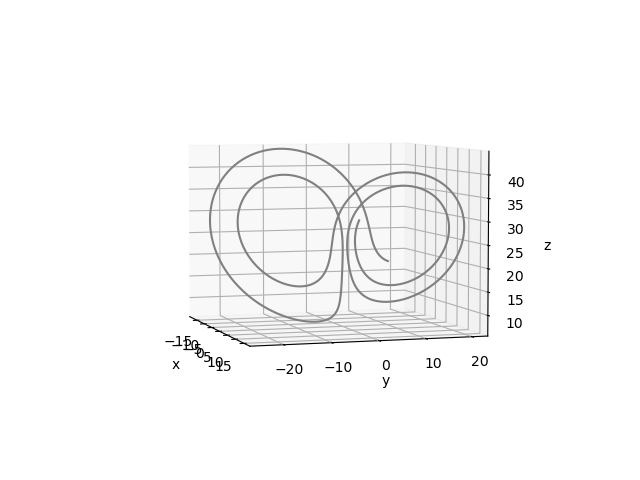

In [7]:
orbit.plot()

In [14]:
orbit.eqn()

OrbitLZ({"shape": [1023, 3], "basis": "modes", "parameters": [3.5, 10, 28, 2.667]})

In [13]:
result = orb.hunt(orbit.resize(32, 3).transform(to='modes'), maxiter=100000, methods='adj',
                  preconditioning=False,
                  verbose=True,
#                   pexp=(2, 0),
                  step_size=1e-8,
                  min_step=1e-15)


-------------------------------------------------------------------------------------------------
Starting l-bfgs-b optimization
Initial guess : OrbitLZ({"shape": [1023, 3], "basis": "modes", "parameters": [3.5, 10, 28, 2.667]})
Constraints : {'t': False, 'sigma': True, 'rho': True, 'b': True}
Initial cost : 38271726.5796185
Target cost tolerance : 1e-06
Maximum iteration number : 100000
-------------------------------------------------------------------------------------------------
#
insufficient cost decrease, (new_cost - cost) / max([new_cost, cost, 1])<ftol decrease ftol to proceed, terminating with cost 10437664.959944956


<IPython.core.display.Javascript object>


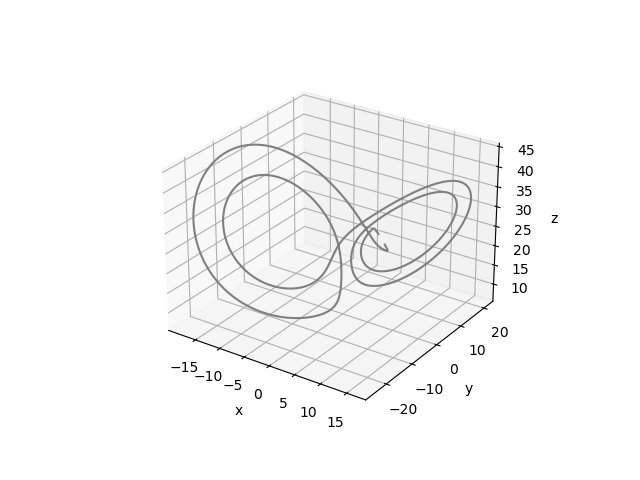

In [11]:
result.orbit.plot()

To check the transforms, let's look at the non-zero modes and how they
arrange real, imaginary components. Because of how the dummy trajectory
was made, there should only be 1 nonzero component per coordinate; imaginary
corresponds to sine, real corresponds to cosine.

We can now plot in 3-d! 

To get the matvec, rmatvec, jacobian expressions, note that we can derive the Jacobian and then simply find a way to evaluate it in a matrix-free manner.


\begin{eqnarray}
 (\omega +\sigma)\tilde{x} - \sigma\tilde{y} = 0 \\
 (\omega +1)\tilde{y} - \rho \tilde{x} + \mathcal{F}(x \cdot z) = 0 \\
 (\omega+b) \tilde{z} - \mathcal{F}(x\cdot y) = 0
\end{eqnarray}

Keep in mind that the tilde variables are vectors of Fourier modes. 

Derivatives w.r.t. $\tilde{x}, \tilde{y}, \tilde{z}$ yield

For $x$

\begin{eqnarray}
 \frac{dFx}{d\tilde{x}} &=& \omega + \text{diag}(\sigma)\\
 \frac{dFx}{d\tilde{y}} &=& -\text{diag}(\sigma)
 \\
 \frac{dFx}{d\tilde{z}} &=& 0 
\end{eqnarray}

For $y$

\begin{eqnarray}
 \frac{dFy}{d\tilde{x}} &=& -\rho + \mathcal{F}\cdot \text{diag}(z) \cdot \mathcal{F}^{-1}\\
 \frac{dFy}{d\tilde{y}} &=& w + I\\
 \frac{dFy}{d\tilde{z}} &=& \mathcal{F}\cdot \text{diag}(x) \cdot \mathcal{F}^{-1}
\end{eqnarray}

For $z$

\begin{eqnarray}
 \frac{dFz}{d\tilde{x}} &=& -\mathcal{F}\cdot \text{diag}(y) \cdot \mathcal{F}^{-1}\\
 \frac{dFz}{d\tilde{y}} &=& -\mathcal{F}\cdot \text{diag}(x) \cdot \mathcal{F}^{-1}\\
 \frac{dFz}{d\tilde{z}} &=& \omega + \text{diag}(b)
\end{eqnarray}

and the partial derivative with respect to $t$ is given by $-1/t * \partial_t xyz$

How do use this information? Well because the orbit_vector is order in
such a manner: $[\tilde{x}_0, \tilde{y}_0, \tilde{z}_0, \tilde{x}_1, \tilde{y}_1, \tilde{z}_1, ...]$, the Jacobian's columns follow the same pattern. The trick is to realize that we can compute the tensor corresponding to each column, and then compile them to get the total Jacobian. The only real tricky part is to understand what the diagonal matrices from the nonlinear terms really mean in terms of matrix-free operations.

For example, in:
$\frac{dF_y}{d\tilde{x}} = -\rho + \mathcal{F}\cdot \text{diag}(z) \cdot \mathcal{F}^{-1}$. The components are given simply by $(\frac{dF_y}{d\tilde{x}})_j$ equal
$-\rho x_j + \mathcal{F}(z_j \cdot x_j)$ so all we need to do is compute the usual pseudospectral product and we're done; the only special property is the order of all Jacobian components.


For the matrix free computations, this simply means that for matrix $J$ and
vector $v$, compute the pseudo spectral products of, for example, $z$ with $v_x$ for the $F_x$ components.


Now, note that if we consider the matvec expressions in their matrix form, transposition only affects the time derivative due to our SO(2) basis;
the transposition is equivalent to multiplying by a negative sign! This makes the deployment of `rmatvec` quick. The only other difference is that the adjoint Jacobian returns a value for the parameter `dt` instead of affecting the modes>

In [14]:
kwargs = {}

In [15]:
# orbit_vector = orbit.orbit_vector()
# # orbit_vector is defined to be concatenation of state and parameters;
# # slice out the parameters; cast as list to gain access to pop
# param_list = list(
#     kwargs.pop("passed_parameters", orbit_vector.ravel()[self.size :])
# )

# # The issue with parsing the parameters is that we do not know which list element corresponds to
# # which parameter unless the constraints are checked. Parameter keys which are not in the constraints dict
# # are assumed to be constrained. Pop from param_list if parameters 1. exist, 2. are unconstrained.
# # Not having enough parameters to pop means something is going wrong in your matvec/rmatvec functions typically.
# parameters = tuple(
#     param_list.pop(0)
#     if (not self.constraints.get(each_label, True) and param_list)
#     else 0.0
#     for each_label in self.parameter_labels()
# )
# test = self.__class__(
#     **{
#         **vars(self),
#         "state": np.reshape(orbit_vector.ravel()[: self.size], self.shape),
#         "parameters": parameters,
#         **kwargs,
#     }
# )


Now that we have the `equations`, `matvec` and `rmatvec` we can already use a large portion of the orbithunter package! 